### [AIFactory] 지하철역 CCTV 영상을 이용한 추적영상 인식 Baseline 코드
### 1. Baseline 코드 링크 (AIfactory)
http://aifactory.space/task/detail.do?taskId=T001633

### 2. Task 및 Data 정의

##### Task
- 이상행동 12가지로 분류하기
- 5종의 대상 (휠체어 이용자, 시각장애인, 유모차 이용자, 잡상인, 아동) 객체 추정

##### Data
- annotation file은 객체 레이블(0~5)과 Bounding Box (XMin YMin Width Height)로 구성되어 있으며, 존재하는 모든 객체에 대하여 정의되어 있다
- 0 : "Person", 1 : "stroller", 2 : "blinder", 3 : "wheelchair", 4 : "child", 5 : "merchant"

### 3. Code


```bash
├── lib
│   ├── augmentation.py
│   ├── model.py
│   ├── utils.py
│   ├── multibox_encoder.py
│   └── ssd_loss.py
├── Dataset.py
├── Config.py
├── train.py
└── eval.py
```



### 4. Model: SSD
- Region Proposal를 제거하고 여러가지 크기의 __Default boxes__를 설정하여 성능과 속도를 높인 1-stage Detector 모델

<img src='img/ssd.png' width='600'>


<SSD(위) vs YOLO(아래)>


> cf) 1-stage Detector vs 2-stage Detector     
>    
>    
> - 2-stage Detector는 물체의 위치를 찾는 __Localization 문제__와 문체를 식별하는 __Classification 문제__를 순차적으로 행하는 방법 (대표적으로 R-CNN계열)
<img src='img/sort_2.png' width='500'>
<center> 2-stage Detector (출처 : hoya012 .github.io)</center>


> - 1-stage Detector는 두 문제를 동시에 행하는 방법 (대표적으로 YOLO계열 SSD계열)
<img src='img/sort_3.png' width='500'>
<center> 1-stage Detector (출처 : hoya012 .github.io)</center>


> - 1-stage Detector vs 2-stage Detector 논문 흐름  
<img src='img/ssd_2.png' width='500'>

In [1]:
import sys
import os
sys.path.append('/content/drive/MyDrive/Colab_Notebooks/AIfactory/code')  # 모듈 저장 디렉토리 설정
os.chdir('/content/drive/MyDrive/Colab_Notebooks/AIfactory/code')

In [12]:
from IPython.display import Image
from tqdm import tqdm

### Lib folder

#### augmentation.py

In [3]:
import cv2
import numpy as np
import random

from lib.utils import bbox_iou

In [4]:
def _crop(image, boxes, labels):
    height, width, _ = image.shape

    # box가 하나도 없으면 그냥 그대로 return 
    if len(boxes) == 0:
        return image, boxes, labels

    while True:
        mode = random.choice((    # random.choice 함수는 원소 중 하나를 랜덤하게 choice!
            None,                 # ex. (0.1, None)을 추출
            (0.1, None),
            (0.3, None),
            (0.7, None),
            (0.9, None),
            (None, None),
        ))

        # mode가 None이면 그대로 return
        if mode is None:
            return image, boxes, labels

        # min_iou와 max_iou가 None이면 각각 -inf, inf로 설정
        min_iou, max_iou = mode
        if min_iou is None:
            min_iou = float('-inf')
        if max_iou is None:
            max_iou = float('inf')

        # for문을 50번 실행하긴 하는데, 중간에 한번이라도 boxes를 추출하면 바로 return!
        for _ in range(50):
            w = random.randrange(int(0.3 * width), width)    # randrange(1, 7)은 1~6까지의 정수 중 임의추출
            h = random.randrange(int(0.3 * height), height)

            # 만약, w와 h가 두배이상 차이나면 다음 for문 step으로 continue해서 다시 crop
            if h / w < 0.5 or 2 < h / w: 
                continue

            # 랜덤하게 설정한 w와 h에 따라 랜덤하게 새로운 bounding box인 roi를 설정
            l = random.randrange(width - w)
            t = random.randrange(height - h)
            roi = np.array((l, t, l + w, t + h))  # xmin, ymin, xmax, ymax

            # 실제 box와 roi의 iou를 구했을 때, 앞서 정의한 min_iou보다 작거나 max_iou보다 크면 다음 for문으로 
            iou = bbox_iou(boxes, roi[np.newaxis])
            if not (min_iou <= iou.min() and iou.max() <= max_iou):
                continue

            # roi에 맞도록 image, boxes, labels
            image = image[roi[1]:roi[3], roi[0]:roi[2]]

            # xmin, ymin이 centers보다 작고, xmax, ymax가 centers보다 큰 (올바른) boxes와 labels만 추출
            centers = (boxes[:, :2] + boxes[:, 2:]) / 2
            mask = np.logical_and(roi[:2] < centers, centers < roi[2:]) \
                     .all(axis=1)
            boxes = boxes[mask].copy()
            labels = labels[mask]
            

            boxes[:, :2] = np.maximum(boxes[:, :2], roi[:2])
            boxes[:, :2] -= roi[:2]
            boxes[:, 2:] = np.minimum(boxes[:, 2:], roi[2:])
            boxes[:, 2:] -= roi[:2]

            return image, boxes, labels

In [5]:
def _distort(image):
    def _convert(image, alpha=1, beta=0):
        tmp = image.astype(float) * alpha + beta
        tmp[tmp < 0] = 0
        tmp[tmp > 255] = 255
        image[:] = tmp

    image = image.copy()

    if random.randrange(2):
        _convert(image, beta=random.uniform(-32, 32))

    if random.randrange(2):
        _convert(image, alpha=random.uniform(0.5, 1.5))

    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    if random.randrange(2):
        tmp = image[:, :, 0].astype(int) + random.randint(-18, 18)
        tmp %= 180
        image[:, :, 0] = tmp

    if random.randrange(2):
        _convert(image[:, :, 1], alpha=random.uniform(0.5, 1.5))

    image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)

    return image

In [6]:
def _expand(image, boxes, fill):
    if random.randrange(2):
        return image, boxes

    height, width, depth = image.shape
    ratio = random.uniform(1, 4)
    left = random.randint(0, int(width * ratio) - width)
    top = random.randint(0, int(height * ratio) - height)

    expand_image = np.empty(
        (int(height * ratio), int(width * ratio), depth),
        dtype=image.dtype)
    expand_image[:, :] = fill
    expand_image[top:top + height, left:left + width] = image
    image = expand_image

    boxes = boxes.copy()
    boxes[:, :2] += (left, top)
    boxes[:, 2:] += (left, top)

    return image, boxes

In [7]:
def _mirror(image, boxes):
    _, width, _ = image.shape
    if random.randrange(2):
        image = image[:, ::-1]
        boxes = boxes.copy()
        boxes[:, 0::2] = width - boxes[:, 2::-2]
    return image, boxes

In [8]:
# test image를 위한 preprocessing
def preproc_for_test(image, insize, mean):
    image = cv2.resize(image, (insize, insize))  # insize, insize 크기로 resize
    image = image.astype(np.float32)
    image -= mean                                # mean으로 빼줌
    return image.transpose(2, 0, 1)              # image의 행렬을 (height, width, channels) -> (channels, height, width)로 바꿔줌


def preproc_for_train(image, boxes, labels, insize, mean):
    if len(boxes) == 0:
        boxes = np.empty((0, 4))

    # image preprocessing
    image, boxes, labels = _crop(image, boxes, labels)
    image = _distort(image)
    image, boxes = _expand(image, boxes, mean)
    image, boxes = _mirror(image, boxes)

    height, width, _ = image.shape
    image = preproc_for_test(image, insize, mean)
    boxes = boxes.copy()
    boxes[:, 0::2] /= width      # 이미지 크기를 변경했으므로 지침에 따라 변경된 이미지 해상도를 기준으로 상대좌표를 변경 (XMin / width), (YMin / height), (XMax / width), (YMax / height)
    boxes[:, 1::2] /= height

    return image, boxes, labels

#### model.py

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import models
import torch.nn.functional as F
import torch.nn.init as init

In [ ]:
class L2Norm(nn.Module):

    def __init__(self, n_channels, scale):
        super(L2Norm, self).__init__()
        self.n_channels = n_channels
        self.gamma = scale or None
        self.eps = 1e-10
        self.weight = nn.Parameter(torch.Tensor(self.n_channels))
        self.reset_parameters()

    def reset_parameters(self):
        init.constant_(self.weight, self.gamma)
        

    def forward(self, x):
        norm = torch.sqrt(x.pow(2).sum(dim=1, keepdim=True)) + self.eps
        x = torch.div(x, norm)
        x = self.weight.unsqueeze(0).unsqueeze(2).unsqueeze(3).expand_as(x) * x
        return x

In [ ]:
models.vgg16().features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [ ]:
def VGG():
    base_vgg = models.vgg16().features
    base_vgg[16].ceil_mode = True        # 16번째 layer의 ceil_mode=True로 설정하여 Output Size에 대하여 바닥 함수대신, 천장 함수를 사용! (천장함수에 대한 설명은 아래 그림 참고)
    vgg = []
    for i in range(30):                  # 30개의 layer 전체를 vgg라는 list로 append
        vgg.append(base_vgg[i])        

    pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)    # kernel size가 3이고, padding(zero padding을 실시 할 사이즈)를 1로 설정한 MaxPooling
    conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)   # in_channel : 512, out_channel : 1024, dilation(dilated conv에서 커널 사이 간격 사이즈 조절) : 6
    conv7 = nn.Conv2d(1024, 1024, kernel_size=1)
    vgg += [pool5, conv6, nn.ReLU(inplace=True), conv7, nn.ReLU(inplace=True)]  # inplace=True : 추가 메모리 할당없이 input으로 들어온 것 자체를 수정하겠다는 뜻
    return vgg


def Extra():
    layers = []
    conv8_1 = nn.Conv2d(1024, 256, kernel_size=1, stride=1)
    conv8_2 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)
    conv9_1 = nn.Conv2d(512, 128, kernel_size=1, stride=1)
    conv9_2 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
    conv10_1 = nn.Conv2d(256, 128, kernel_size=1, stride=1)
    conv10_2 = nn.Conv2d(128, 256, kernel_size=3, stride=1)
    conv11_1 = nn.Conv2d(256, 128, kernel_size=1)
    conv11_2 = nn.Conv2d(128, 256, kernel_size=3, stride=1)

    layers = [conv8_1, conv8_2, conv9_1, conv9_2, conv10_1, conv10_2, conv11_1, conv11_2]

    return layers


def Feature_extractor(vgg, extral, bboxes, num_classes):

    loc_layers = []
    conf_layers = []
    vgg_useful = [21, 33]
    
    for k, v in enumerate(vgg_useful):  
        loc_layers += [nn.Conv2d(vgg[v].out_channels,
                                 bboxes[k] * 4, kernel_size=3, padding=1)]
        conf_layers += [nn.Conv2d(vgg[v].out_channels,
                        bboxes[k] * num_classes, kernel_size=3, padding=1)]

    for k, v in enumerate(extral[1::2], 2):        # enumerate의 두번째 인자(2)의 의미는 index를 2부터 시작하겠다는 의미
        loc_layers += [nn.Conv2d(v.out_channels,
                                 bboxes[k] * 4, kernel_size=3, padding=1)]
        conf_layers += [nn.Conv2d(v.out_channels, 
                                  bboxes[k] * num_classes, kernel_size=3, padding=1)]
    
    return loc_layers, conf_layers 



class SSD(nn.Module):

    def __init__(self, num_classes, bboxes):
        super(SSD, self).__init__()

        self.num_classes = num_classes
        self.bboxes = bboxes 

        self.vgg_list = VGG()
        self.extra_list = Extra()

        self.loc_layers_list, self.conf_layers_list = Feature_extractor(self.vgg_list, self.extra_list, self.bboxes, self.num_classes)

        self.L2Norm = L2Norm(512, 20)


        self.vgg = nn.ModuleList(self.vgg_list)         # nn.ModuleList : nn.ModuleList를 반환. nn.Module 객체의 member로서 nn.ModuleList를 추가할 때,
        self.extras = nn.ModuleList(self.extra_list)    # nn.ModuleList에 있는 nn.Module 객체의 모든 parameter들이 nn.Module 객체의 parameter로 추가됨
        self.loc = nn.ModuleList(self.loc_layers_list)
        self.conf = nn.ModuleList(self.conf_layers_list)


    def forward(self, x):

        source = []
        loc = []
        conf = []

        vgg_source = [22, 34]

        # vgg forward 해주기
        for i, v in enumerate(self.vgg):
            x = v(x)

            # vgg_source(22, 34)번째 layer의 경우, layer의 output을 source에 append (21은 l2norm해주기)
            if i in vgg_source:
                if i == 22:
                    s = self.L2Norm(x)
                else:
                    s = x
                source.append(s)

        # extra forward 해주기
        for i, v in enumerate(self.extras):
            x = F.relu(v(x), inplace=True)
            if i % 2 == 1:         # 홀수번째 layer 결과를 source에 append
                source.append(x)


        for s, l, c in zip(source, self.loc, self.conf):
            loc.append(l(s).permute(0, 2, 3, 1).contiguous())   # permute로 순서 바꿔주기 
            conf.append(c(s).permute(0, 2, 3, 1).contiguous())  # contiguous : transpose나 permute를 이용하여 순서를 바꿔주면 실제 데이터의 위치가 바뀌는 것이 
                                                                # 아니라, 접근 인덱스만 바뀌므로 이러한 비연속적인 텐서를 연속적으로 만들어주는 역할

        loc = torch.cat([o.view(o.size(0), -1) for o in loc], 1)    # dim을 1로 설정하여 concatenate! (예시구현은 아래 참고)
        conf = torch.cat([o.view(o.size(0), -1) for o in conf], 1)  # view : np.reshape와 같은 의미 (o.size(0), -1)로 reshape

        loc = loc.view(loc.size(0), -1, 4)
        conf = conf.view(conf.size(0), -1, self.num_classes)

        return loc, conf


if __name__ == '__main__':

    x = torch.randn(1, 3, 300, 300) 
    ssd = SSD(21, [4,6,6,6,4,4])

    y = ssd(x)
    print(y[0].shape, y[1].shape)

##### cf) 바닥 함수와 천장 함수

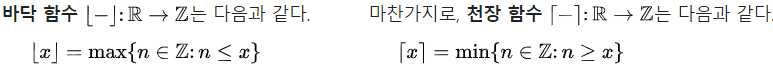

In [ ]:
Image('../img/ceil_function.png', width=800)

##### cf) torch.cat 구현

In [ ]:
x = torch.FloatTensor([[1, 2], [3, 4]])
y = torch.FloatTensor([[5, 6], [7, 8]])

print(torch.cat([x, y], dim=1))

tensor([[1., 2., 5., 6.],
        [3., 4., 7., 8.]])


#### utils.py


In [ ]:
import numpy as np
import torch
import cv2

In [ ]:
# default boxes를 (x center, y center, s, s) -> (xmin, ymin, xmax, ymax)로 변경해주는 함수
def point_form(boxes):

    tl = boxes[:, :2] - boxes[:, 2:]/2
    br = boxes[:, :2] + boxes[:, 2:]/2

    return np.concatenate([tl, br], axis=1)


def detection_collate(batch):

    targets = []
    imgs = []
    for sample in batch:
        imgs.append(sample[0])
        targets.append(sample[1])
    return torch.stack(imgs), np.array(targets)


# IoU 계산하는 코드 (IoU에 대한 설명은 아래 그림 참고)
def bbox_iou(box_a, box_b):

    m = box_a.shape[0]
    n = box_b.shape[0]

    tl = np.maximum(box_a[:, None, :2], box_b[None, :, :2])
    br = np.minimum(box_a[:, None, 2:], box_b[None, :, 2:])

    wh = np.maximum(br-tl, 0)
    
    inner = wh[:, :, 0]*wh[:, :, 1]

    a = box_a[:, 2:] - box_a[:, :2]
    b = box_b[:, 2:] - box_b[:, :2]

    a = a[:, 0] * a[:, 1]
    b = b[:, 0] * b[:, 1]

    a = a[:, None]
    b = b[None, :]

    return inner / (a+b-inner)

##### cf) IoU (Intersection over Union) 란?

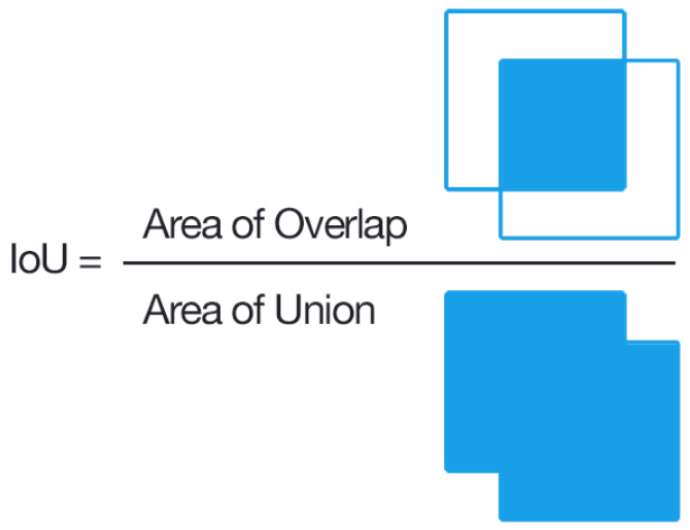

In [ ]:
Image(os.path.join(root, '../img/iou.png'), width=300)

In [ ]:
def nms(boxes, score, threshold=0.4):

    sort_ids = np.argsort(score)
    pick = []
    while len(sort_ids) > 0:
        i = sort_ids[-1]
        pick.append(i)
        if len(sort_ids) == 1:
            break

        sort_ids = sort_ids[:-1]
        box = boxes[i].reshape(1, 4)
        ious = bbox_iou(box, boxes[sort_ids]).reshape(-1)

        sort_ids = np.delete(sort_ids, np.where(ious > threshold)[0])

    return pick




def detect(locations, scores, nms_threshold, gt_threshold):

    scores = scores[:, 1:] 

    keep_boxes = []
    keep_confs = []
    keep_labels = []

    for i in range(scores.shape[1]):

        mask = scores[:, i] >= gt_threshold
        label_scores = scores[mask, i] 
        label_boxes = locations[mask]

        if len(label_scores) == 0:
            continue

        pick = nms(label_boxes, label_scores, threshold=nms_threshold)
        label_scores = label_scores[pick]
        label_boxes = label_boxes[pick]
        

        keep_boxes.append(label_boxes.reshape(-1))
        keep_confs.append(label_scores)
        keep_labels.extend([i]*len(label_scores))

    if len(keep_boxes) == 0:
        return np.array([]), np.array([]), np.array([])
        
    
    keep_boxes = np.concatenate(keep_boxes, axis=0).reshape(-1, 4)

    keep_confs = np.concatenate(keep_confs, axis=0)
    keep_labels = np.array(keep_labels).reshape(-1)

    return keep_boxes, keep_confs, keep_labels





def draw_rectangle(src_img, labels, conf, locations, label_map):

    num_obj = len(labels)
    COLORS = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]
    FONT = cv2.FONT_HERSHEY_SIMPLEX
    img = src_img.copy()
    for i in range(num_obj):
        tl = tuple(locations[i][:2])
        br = tuple(locations[i][2:])
        
        cv2.rectangle(img,
                      tl,
                      br,
                      COLORS[i%3], 3)
        cv2.putText(img, label_map[labels[i]], tl,
                    FONT, 1, (255, 255, 255), 2)
    
    img = img[:, :, ::-1]

    return img

#### multibox_encoder.py

In [ ]:
import itertools
import numpy as np

from lib.utils import bbox_iou
from lib.utils import point_form

In [ ]:
class MultiBoxEncoder(object):

    def __init__(self, opt):
        self.variance = opt.variance

        default_boxes = list()
        for k in range(len(opt.grids)):

            for v, u in itertools.product(range(opt.grids[k]), repeat=2):   # itertools.product('ABCD', repeat=2)
                                                                            # 결과: AA AB AC AD BA BB BC BD CA CB CC CD DA DB DC DD

                # config에서 설정된 opt의 값들
                # opt.grids = (38, 19, 10, 5, 3, 1)
                # opt.steps = [s / 300 for s in (8, 16, 32, 64, 100, 300)]           # [0.02666666666666667, 0.05333333333333334, 0.10666666666666667, 0.21333333333333335, 0.3333333333333333, 1.0]
                # opt.sizes = [s / 300 for s in (30, 60, 111, 162, 213, 264, 315)]   # [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05]

                cx = (u + 0.5) * opt.steps[k]
                cy = (v + 0.5) * opt.steps[k]

                s = opt.sizes[k]
                default_boxes.append((cx, cy, s, s))

                s = np.sqrt(opt.sizes[k] * opt.sizes[k + 1])
                default_boxes.append((cx, cy, s, s))

                s = opt.sizes[k]
                for ar in opt.aspect_ratios[k]:
                    default_boxes.append(
                        (cx, cy, s * np.sqrt(ar), s / np.sqrt(ar)))
                    default_boxes.append(
                        (cx, cy, s / np.sqrt(ar), s * np.sqrt(ar)))

        default_boxes = np.clip(default_boxes, a_min=0, a_max=1)
        self.default_boxes = np.array(default_boxes)


    def encode(self, boxes, labels, threshold=0.5):

        if len(boxes) == 0:
            return (
                np.zeros(self.default_boxes.shape, dtype=np.float32),
                np.zeros(self.default_boxes.shape[:1], dtype=np.int32))

        iou = bbox_iou(point_form(self.default_boxes), boxes)

        gt_idx = iou.argmax(axis=1)
        iou = iou.max(axis=1)
        boxes = boxes[gt_idx]
        labels = labels[gt_idx]

        # center(x), center(y), w, h로 바꿔주고, conf를 1 + labels로 정의해주기
        loc = np.hstack((
            ((boxes[:, :2] + boxes[:, 2:]) / 2 - self.default_boxes[:, :2]) /
            (self.variance[0] * self.default_boxes[:, 2:]),
            np.log((boxes[:, 2:] - boxes[:, :2]) / self.default_boxes[:, 2:]) /
            self.variance[1]))

        conf = 1 + labels
        conf[iou < threshold] = 0
       
        return loc.astype(np.float32), conf.astype(np.int32)

    # Inference시 output을 decode!
    def decode(self, loc):

        boxes = np.hstack((
            self.default_boxes[:, :2] +
            loc[:, :2] * self.variance[0] * self.default_boxes[:, 2:],
            self.default_boxes[:, 2:] * np.exp(loc[:, 2:] * self.variance[1])))
        
        # xmin, ymin, xmax, ymax로 바꿔주기
        boxes[:, :2] -= boxes[:, 2:] / 2
        boxes[:, 2:] += boxes[:, :2]

        return boxes


if __name__ == '__main__':
    from config import opt
    mb = MultiBoxEncoder(opt)

    print(mb.default_boxes[:10])

##### cf) default_boxes 확인

In [ ]:
 mb = MultiBoxEncoder(opt)

In [ ]:
for i in range(20):
    print(mb.default_boxes[i])

[0.01333333 0.01333333 0.1        0.1       ]
[0.01333333 0.01333333 0.14142136 0.14142136]
[0.01333333 0.01333333 0.14142136 0.07071068]
[0.01333333 0.01333333 0.07071068 0.14142136]
[0.04       0.01333333 0.1        0.1       ]
[0.04       0.01333333 0.14142136 0.14142136]
[0.04       0.01333333 0.14142136 0.07071068]
[0.04       0.01333333 0.07071068 0.14142136]
[0.06666667 0.01333333 0.1        0.1       ]
[0.06666667 0.01333333 0.14142136 0.14142136]
[0.06666667 0.01333333 0.14142136 0.07071068]
[0.06666667 0.01333333 0.07071068 0.14142136]
[0.09333333 0.01333333 0.1        0.1       ]
[0.09333333 0.01333333 0.14142136 0.14142136]
[0.09333333 0.01333333 0.14142136 0.07071068]
[0.09333333 0.01333333 0.07071068 0.14142136]
[0.12       0.01333333 0.1        0.1       ]
[0.12       0.01333333 0.14142136 0.14142136]
[0.12       0.01333333 0.14142136 0.07071068]
[0.12       0.01333333 0.07071068 0.14142136]


#### ssd_loss.py

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
def hard_negtives(logits, labels, pos, neg_radio):  # 실제로는 negative인데 positive라고 잘못 예측하기 쉬운 데이터 (FP)

    num_batch, num_anchors, num_classes = logits.shape
    logits = logits.view(-1, num_classes)
    labels = labels.view(-1)

    losses = F.cross_entropy(logits, labels, reduction='none')
    losses = losses.view(num_batch, num_anchors)

    losses[pos] = 0

    loss_idx = losses.argsort(1, descending=True)
    rank = loss_idx.argsort(1) #(batch, n)

    num_pos = pos.long().sum(1, keepdim=True)  # torch.long == torch.int64
    num_neg = torch.clamp(neg_radio*num_pos, max=pos.shape[1]-1) #(batch, 1)  # clamp : input 모든 요소를 min 보다 크거나 같도록 클램프
    neg = rank < num_neg.expand_as(rank)
    
    return neg
    
class MultiBoxLoss(nn.Module):

    def __init__(self, num_classes=7, neg_radio=3):
        super(MultiBoxLoss, self).__init__()
        self.num_classes = num_classes
        self.neg_radio = neg_radio
    
    def forward(self, pred_loc, pred_label, gt_loc, gt_label):
        '''
        pred_loc : (batch, anchor_num, 4)
        pred_label : (batch, anchor_num, num_classes)
        gt_loc : (batch, anchor_num, 4)
        gt_label : (batch, anchor_num)
        '''

        num_batch = pred_loc.shape[0]

        pos_idx = gt_label > 0
        pos_loc_idx = pos_idx.unsqueeze(2).expand_as(pred_loc)
        pred_loc_pos = pred_loc[pos_loc_idx].view(-1, 4)
        gt_loc_pos = gt_loc[pos_loc_idx].view(-1, 4)

        loc_loss = F.smooth_l1_loss(pred_loc_pos, gt_loc_pos, reduction='sum')

        logits = pred_label.detach()
        labels = gt_label.detach()
        neg_idx = hard_negtives(logits, labels, pos_idx, self.neg_radio) #neg (batch, n)

        pos_cls_mask = pos_idx.unsqueeze(2).expand_as(pred_label)
        neg_cls_mask = neg_idx.unsqueeze(2).expand_as(pred_label)

        conf_p = pred_label[(pos_cls_mask+neg_cls_mask).gt(0)].view(-1, self.num_classes)
        target = gt_label[(pos_idx+neg_idx).gt(0)]

        cls_loss = F.cross_entropy(conf_p, target, reduction='sum')
        N = pos_idx.long().sum()

        loc_loss /= N
        cls_loss /= N


        return loc_loss, cls_loss

### Dataset.py

In [4]:
import torch
import torch.utils.data as data
import xml.etree.ElementTree as ET
import numpy as np
import glob
import os
import cv2
from config import opt
from lib.augmentations import preproc_for_test, preproc_for_train

In [5]:
PERSON_LABELS = (
        'Person',
        'stroller',
        'blinder',
        'wheelchair',
        'child',
        'merchant',
    )

In [6]:
class CCTVDetection(data.Dataset):


    def __init__(self,is_train=True):

        self.is_train = is_train
        self.opt = opt
        self.ids = []
        root = '/content/drive/MyDrive/Colab_Notebooks/AIfactory/data'

        # is_train == True인 경우, train data를 가져옴
        if self.is_train:
            img_file = os.path.join(root,'train_img/*')
            ano_file = os.path.join(root,'train_label/*')
            file_list = glob.glob(img_file)
            file_list_img = [file for file in file_list if file.endswith(".jpg")]

            # 모든 file_list_img의 img, annotation 경로를 ids에 append 해줌
            for i in file_list_img:
                file_name = os.path.split(i)[1].split('.')[0]  # jpg의 파일이름을 추출
                img = f"{root}/train_img/{file_name}.jpg"
                ano = f"{root}/train_label/{file_name}.txt"
                # ano = os.path.join("dataset/train_label",file_name + '.txt')
                # img = os.path.join("dataset/train_img",file_name + '.jpg')
                
                if os.path.isfile(ano) and os.path.isfile(img):  # 만약 ano 파일이나 img 파일이 존재하는 일반 파일이면
                    self.ids.append((img, ano))                  # ids 리스트에 (img, ano 경로 문자열)을 append
        
        # is_train == False 경우, test data를 가져옴
        else:
            img_file = os.path.join(root,'test_img/*')
            file_list = glob.glob(img_file)
            file_list_img = [file for file in file_list if file.endswith(".jpg")]
            for i in file_list_img:
                self.ids.append((i))
            
    
    def __getitem__(self, index):

        # train data에 대하여 preproecessing 해준다음, boxes와 label를 target 리스트로 만들어 return
        if self.is_train:
            img_path, ano_path = self.ids[index]
            image = cv2.imread(img_path, cv2.IMREAD_COLOR)
            boxes, labels = self.get_annotations(ano_path)

            if self.is_train:
                image, boxes, labels = preproc_for_train(image, boxes, labels, opt.min_size, opt.mean)
                image = torch.from_numpy(image)

            target = np.concatenate([boxes, labels.reshape(-1,1)], axis=1)
            return image, target

        # test data에 대하여 image만 리턴
        else:
            img_path = self.ids[index]
            image = cv2.imread(img_path, cv2.IMREAD_COLOR)
            return image
    
    # Bounding Box와 Label를 return 해주는 함수
    def get_annotations(self, path):
        
        f = open(path, 'r')
        det = f.readlines()
        boxes = []
        labels = []
        for d in det:
            obj = d.split(' ')
            label = int(obj[0])
            box = [float(obj[1]),float(obj[2]),float(obj[1])+float(obj[3]),float(obj[2])+float(obj[4])]
            boxes.append(box)
            labels.append(label)
        return np.array(boxes), np.array(labels)
            

    def __len__(self):
        return len(self.ids)

### Config.py

In [7]:
class Config:
    VOC_ROOT = '/workspace/hakerton/simple-ssd-for-beginners/VOCdevkit'
    num_classes = 7
    resume = None
    lr = 0.0005
    batch_size = 64 
    momentum = 0.9
    weight_decay = 5e-4
    epoch = 100 
    gamma = 0.2
    lr_reduce_epoch = 30
    save_folder = 'weights/'
    basenet = 'vgg16_reducedfc.pth'
    log_fn = 1
    neg_radio = 3
    min_size = 300
    grids = (38, 19, 10, 5, 3, 1)
    aspect_ratios = ((2,), (2, 3), (2, 3), (2, 3), (2,), (2,))
    steps = [s / 300 for s in (8, 16, 32, 64, 100, 300)]
    sizes = [s / 300 for s in (30, 60, 111, 162, 213, 264, 315)] 
    anchor_num = [4, 6, 6, 6, 4, 4]
    mean = (104, 117, 123)
    variance = (0.1, 0.2)

opt = Config()

### train.py

In [8]:
from config import opt
import numpy as np
from lib.model import SSD
import torch
import torch.nn.functional as F
import os
from lib.utils import detection_collate
from lib.multibox_encoder import MultiBoxEncoder
from lib.ssd_loss import MultiBoxLoss
# from dataset import CCTVDetection      # dataset.py는 import 오류가 발생하여 직접 실행

In [ ]:
## GPU 설정
# device = torch.device('cuda')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# config.py 파일의 config를 출력해주는 함수
def print_config(path):
    with open(path, 'r') as f:
        for line in f.readlines():
            if '=' in line:
                print(line)

# adjust learning rate 설정하는 함수
def adjust_learning_rate(optimizer, gamma, step):
    """Sets the learning rate to the initial LR decayed by 10 at every
        specified step
    # Adapted from PyTorch Imagenet example:
    # https://github.com/pytorch/examples/blob/master/imagenet/main.py
    """
    lr = opt.lr * (gamma ** (step))
    print('change learning rate, now learning rate is :', lr)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


if __name__ == '__main__':

    print_config('config.py')
    print('now runing on device : ', device)

    # weight 폴더 만들어주기
    if not os.path.exists(opt.save_folder):
        os.mkdir(opt.save_folder)
    
    # Model 정의
    model = SSD(opt.num_classes, opt.anchor_num)
    
    # load base network or load checkpoint
    if opt.resume:
        print('loading checkpoint...')
        model.load_state_dict(torch.load(opt.resume))
    else:
        vgg_weights = torch.load(opt.save_folder + opt.basenet)
        print('Loading base network...')
        model.vgg.load_state_dict(vgg_weights)

    # 현재 GPU를 사용 중일때 GPU 연산을 할 수 있도록 지정
    model.to(device)
    model.train()

    # Data 로드
    mb = MultiBoxEncoder(opt)
    dataset = CCTVDetection(opt)   # image와 label에 대한 개체
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=opt.batch_size, collate_fn=detection_collate, num_workers=0)
        # collate_fn : 데이터를 batch로 처리하기 위해 사용하는 인자 (미리 선언된 데이터 처리 파이프라인에 따라)
        # detection_collate 파이프라인은 utils에 정의되어 있으며, torch.stack(imgs), np.array(targets)를 리턴

    # Loss 계산하는 객체와 optimizer 설정
    criterion = MultiBoxLoss(opt.num_classes, opt.neg_radio).to(device)   
    optimizer = torch.optim.SGD(model.parameters(), lr=opt.lr, momentum=opt.momentum,
                          weight_decay=opt.weight_decay)


    print('start training........')
    # Epochs
    for e in tqdm(range(opt.epoch)):
        if e % opt.lr_reduce_epoch == 0:
            adjust_learning_rate(optimizer, opt.gamma, e//opt.lr_reduce_epoch)   # lr_reduce_epoch(30)마다 weight decay
        
        total_loc_loss = 0
        total_cls_loss = 0
        total_loss = 0

        # Batches
        for i , (img, boxes) in enumerate(dataloader):
            img = img.to(device)
            gt_boxes = []
            gt_labels = []

            # Boxes
            for box in boxes:
                labels = box[:, 4]
                box = box[:, :-1]
                match_loc, match_label = mb.encode(box, labels)
            
                gt_boxes.append(match_loc)
                gt_labels.append(match_label)
            
            gt_boxes = torch.FloatTensor(gt_boxes).to(device)
            gt_labels = torch.LongTensor(gt_labels).to(device)

            # predict
            p_loc, p_label = model(img)  
            
            # loss 계산
            loc_loss, cls_loss = criterion(p_loc, p_label, gt_boxes, gt_labels)
            loss = loc_loss + cls_loss

            # gradient
            optimizer.zero_grad()  # 역전파 계산 전, gradient 0으로 만들어주기
            loss.backward()        # gradient 계산
            optimizer.step()       # 매개변수 갱신
            
            # epoch의 전체 loss
            total_loc_loss += loc_loss.item()
            total_cls_loss += cls_loss.item()
            total_loss += loss.item()

            # 배치의 loss 평균
            if i % opt.log_fn == 0:
                avg_loc = total_loc_loss / (i+1)
                avg_cls = total_cls_loss / (i+1)
                avg_loss = total_loss / (i+1)
                print('epoch[{}] | batch_idx[{}] | loc_loss [{:.2f}] | cls_loss [{:.2f}] | avg_loss [{:.2f}]'.format(e, i, avg_loc, avg_cls, avg_loss))

        # epoch 마다 모델 저장
        if (e+1) % 1 == 0:
            torch.save(model.state_dict(), os.path.join(opt.save_folder, 'loss-{:.2f}.pth'.format(total_loss)))
            # torch.save(model.state_dict(), PATH)  --  모델 저장코드

    VOC_ROOT = '/workspace/hakerton/simple-ssd-for-beginners/VOCdevkit'

    num_classes = 7

    resume = None

    lr = 0.0005

    batch_size = 64 

    momentum = 0.9

    weight_decay = 5e-4

    epoch = 100 

    gamma = 0.2

    lr_reduce_epoch = 30

    save_folder = 'weights/'

    basenet = 'vgg16_reducedfc.pth'

    log_fn = 1

    neg_radio = 3

    min_size = 300

    grids = (38, 19, 10, 5, 3, 1)

    aspect_ratios = ((2,), (2, 3), (2, 3), (2, 3), (2,), (2,))

    steps = [s / 300 for s in (8, 16, 32, 64, 100, 300)]

    sizes = [s / 300 for s in (30, 60, 111, 162, 213, 264, 315)] 

    anchor_num = [4, 6, 6, 6, 4, 4]

    mean = (104, 117, 123)

    variance = (0.1, 0.2)

opt = Config()

now runing on device :  cuda
Loading base network...
start training........
change learning rate, now learning rate is : 0.0005


/content/drive/My Drive/Colab_Notebooks/AIfactory/code/lib/utils.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return torch.stack(imgs), np.array(targets)


epoch[0] | batch_idx[0] | loc_loss [2.81] | cls_loss [12.18] | avg_loss [14.99]
epoch[0] | batch_idx[1] | loc_loss [2.99] | cls_loss [11.75] | avg_loss [14.74]
epoch[0] | batch_idx[2] | loc_loss [3.04] | cls_loss [11.25] | avg_loss [14.29]
epoch[0] | batch_idx[3] | loc_loss [2.93] | cls_loss [10.77] | avg_loss [13.69]
epoch[0] | batch_idx[4] | loc_loss [2.89] | cls_loss [10.46] | avg_loss [13.35]
epoch[0] | batch_idx[5] | loc_loss [2.85] | cls_loss [10.11] | avg_loss [12.96]
epoch[0] | batch_idx[6] | loc_loss [2.81] | cls_loss [9.86] | avg_loss [12.67]
epoch[0] | batch_idx[7] | loc_loss [2.77] | cls_loss [9.71] | avg_loss [12.48]
epoch[0] | batch_idx[8] | loc_loss [2.74] | cls_loss [9.61] | avg_loss [12.34]
epoch[0] | batch_idx[9] | loc_loss [2.72] | cls_loss [9.54] | avg_loss [12.26]
epoch[0] | batch_idx[10] | loc_loss [2.70] | cls_loss [9.45] | avg_loss [12.16]
epoch[0] | batch_idx[11] | loc_loss [2.68] | cls_loss [9.35] | avg_loss [12.03]
epoch[0] | batch_idx[12] | loc_loss [2.67] |

### eval.py

In [ ]:
import csv
from dataset import CCTVDetection
from dataset import PERSON_LABELS
from config import opt
import numpy as np
from lib.model import SSD
import torch
import torch.nn.functional as F
import os 
from lib.multibox_encoder import MultiBoxEncoder
from lib.ssd_loss import MultiBoxLoss
import cv2
from lib.utils import nms
from lib.augmentations import preproc_for_test
import matplotlib.pyplot as plt
from lib.utils import detect
import tqdm
import os
import argparse

In [ ]:
def convert_to_xyxy(imgWidth, imgHeight, xywh):
    px = float(xywh[0])
    py = float(xywh[1])
    pw = float(xywh[2])
    ph = float(xywh[3])
    
    cpx = px + pw/2
    cpy = py + ph/2

    abspx = cpx / imgWidth
    abspy = cpy / imgHeight
    abspw = pw / imgWidth
    absph = ph / imgHeight  

    abspx = 0.999999 if abspx >= 1 else abspx
    abspy = 0.999999 if abspy >= 1 else abspy
    abspw = 0.999999 if abspw >= 1 else abspw
    absph = 0.999999 if absph >= 1 else absph
    abspx = 0.000001 if abspx < 0 else abspx
    abspy = 0.000001 if abspy < 0 else abspy
    abspw = 0.000001 if abspw < 0 else abspw
    absph = 0.000001 if absph < 0 else absph
            
    return abspx, abspy, abspw, absph

# argparse를 이용하여 model parsing
parser = argparse.ArgumentParser()
parser.add_argument('--model', 
                    default='weights/loss-1451.01.pth',
                    type=str,
                    help='model checkpoint used to eval CCTV dataset')

args = parser.parse_args()  # 명령창에서 주어진 인자를 파싱
checkpoint = args.model

# GPU 설정
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

if __name__ == '__main__': 
    
    # Create Model instance
    print('using {} to eval, use cpu may take an hour to complete !!'.format(device))
    model = SSD(opt.num_classes, opt.anchor_num)
    
    # Load Checkpoint
    print('loading checkpoint from {}'.format(checkpoint))
    state_dict = torch.load(checkpoint, map_location=None if torch.cuda.is_available() else 'cpu')
    model.load_state_dict(state_dict)  # load parameters
    model.to(device)
    print('model loaded')
    
    multibox_encoder = MultiBoxEncoder(opt)
    test_dataset = CCTVDetection(False)

    print('start detect.........')
    
    f = open('pred.csv','w', newline='')
    wr = csv.writer(f)
    wr.writerow(["ImageID","LabelName","Conf","XMin","XMax","YMin","YMax"])
    

    for i in tqdm.tqdm(range(len(test_dataset))):

        src = test_dataset[i]
        img_name = os.path.basename(test_dataset.ids[i][19:-4])
        image = preproc_for_test(src, opt.min_size, opt.mean)
        image = torch.from_numpy(image).to(device)

        # predict
        with torch.no_grad():
            loc, conf = model(image.unsqueeze(0))  # unsqueeze : 특정 위치에 1인 차원을 추가
        loc = loc[0]
        conf = conf[0]
        conf = F.softmax(conf, dim=1)    # normalizes values along axis 1
        conf = conf.cpu().numpy()        # move the tensor to cpu
        loc = loc.cpu().numpy()

        decode_loc = multibox_encoder.decode(loc)
        gt_boxes, gt_confs, gt_labels = detect(decode_loc, conf, nms_threshold=0.5, gt_threshold=0.5)

        #no object detected
        if len(gt_boxes) == 0:
            continue

        h, w = src.shape[:2]
        gt_boxes[:, 0] = gt_boxes[:, 0] * w
        gt_boxes[:, 1] = gt_boxes[:, 1] * h
        gt_boxes[:, 2] = gt_boxes[:, 2] * w
        gt_boxes[:, 3] = gt_boxes[:, 3] * h
        
        for box, label, score in zip(gt_boxes, gt_labels, gt_confs):
            box[0],box[1],box[2],box[3] = convert_to_xyxy(w,h,[box[0],box[1],box[2],box[3]])
            wr.writerow([img_name,list(PERSON_LABELS)[label],"{:.3f}".format(score),"{:.8f}".format(box[0]),"{:.8f}".format(box[1]),"{:.8f}".format(box[2]),"{:.8f}".format(box[3])])

    
    f.close()
